# Financial Model Backtesting: Are historic stock returns compatible with a specified stochastic model?

This document implements a simple backtesting methodology to assess, whether a given stock price process
is compatible with a predefined stochastic model. Similar test are employed by numerous investment firms
within regulatory model backtesting.

This document serves as an illustration of techniques and limitations and is intended solely for educational and entertainment purpose.

In [1]:
# Let's load what we will need
import pandas as pd
import numpy as np
import statsmodels.sandbox.distributions.extras as extras
import statsmodels.distributions.empirical_distribution as empirical_distribution
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import matplotlib.patches as mpatches

## Warum Up: Check if a sample is likely to have been taken from a normal distribution with specified mean and variance

Main steps are:
 1. Create a reference sample from the model.
 2. Create a good and a bad sample that are respectively tested against the model sample. 
    1. The good sample is taken from the model.
    2. The bad sample is taken from another distribution
 3. Probability Integral Transform (PIT) is computed based on the model distribution and applied to the good and bad samples.
 4. The obtained PIT values are tested against uniformity using standard tests and p-Values are computed.

In [2]:
# Sorry PEP8 for camelCase throughout.

# Let's take a sample from a specified normal distribution and test if it came from another normal distribution.
modelSample = np.random.normal(2,1,10000) #this is sampled from our 'model'. Later this will be the model of stock prices
testSample = np.random.normal(2,1,100) #A much smaller 'test sample'. This will be the 'realized returns'

badTestSample = np.random.normal(1.5,1,100) #This is quite extreme, but it serves the illustration purpose

In [3]:
# We compute the Probability Integral Transform (PIT) of our test sample: 
# https://en.wikipedia.org/wiki/Probability_integral_transform

# The point is that if the test sample has been sampled from the distribution of the model, then we expect
# that we obtain a uniform distribution

# To compute the PIT we begin by setting up the empirical cumulative distribution function (ECDF) of our model:
empiricalModelCDF = empirical_distribution.ECDF(modelSample)

# We plug in the testSamples to compute the PITs
pitValues = empiricalModelCDF(testSample)
badPITValues = empiricalModelCDF(badTestSample)

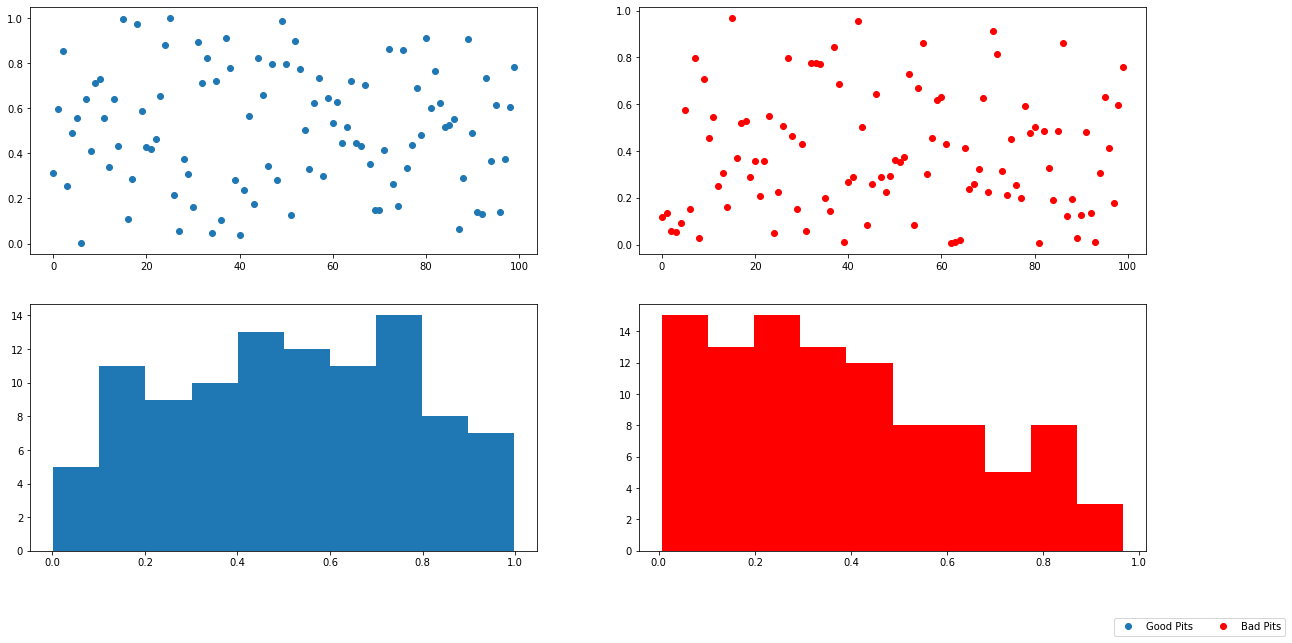

In [4]:
#Plot p values and histograms to visually assess if they are uniform

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(pitValues, 'o')
axs[0, 1].plot(badPITValues, 'o', c = 'red')
axs[1, 0].hist(pitValues, bins =10)
axs[1, 1].hist(badPITValues, bins =10, color = 'red')

fig.legend(['Good Pits','Bad Pits'], loc='lower right', bbox_to_anchor=(1,0.0), ncol=2, bbox_transform=fig.transFigure)

Observe that the histogram on the left hand side much more resembles a uniform distribution than the one on the right hand side.

In [5]:
# We run classical statistical tests to check if the sample truely came from the model

# Let's start with the good sample
ksTest = ss.kstest(pitValues, 'uniform') #Kholmogorov Smirnoff Test
cmTest = ss.cramervonmises(pitValues, 'uniform') #Cramer von Mises Test

# What about the bad sample?
badKSTest = ss.kstest(badPITValues, 'uniform') #Kholmogorov Smirnoff Test
badCMTest = ss.cramervonmises(badPITValues, 'uniform') #Cramer von Mises Test

In [6]:
#Print the measured test statistics and pValues.

print('Good sample: ' + str(ksTest))
print('Good sample: ' + str(cmTest))

print('Bad sample: ' + str(badKSTest))
print('Bad sample: ' + str(badCMTest))

Good sample: KstestResult(statistic=0.08029999999999998, pvalue=0.5134281128835794)
Good sample: CramerVonMisesResult(statistic=0.12205153333333331, pvalue=0.4878990120100065)
Bad sample: KstestResult(statistic=0.20409999999999995, pvalue=0.00039531088611652126)
Bad sample: CramerVonMisesResult(statistic=1.663407193333333, pvalue=6.620792756373284e-05)


We conclude that the bad sample is quite extreme given the model, while the probability of obtaining a test outcome at least as extreme as the one measured is high for the true sample. For completeness one should also run some confidence interval test, but I'll skip this for now.

## Check if a specific path is likely a realization of a Geometric Brownian Motion with specified mean and variance


We roughly follow the main steps of the preceding section: Creating a reference sample from a specified model and comparing a good and a bad path to the reference. 
The main differences with respect to above setting are:
 1. Non-stationarity: The model depends on time. Every sample is taken from a new distribution.
 2. One historic path: In reality only one historic realization of a stock price process is available.

The model used here will be of Geometric Brownian Motion (GBM) type. Only one 'good' and one 'bad' path will be created for this example. In order to test the hypothesis that the 'good' or 'bad' path came from the specified model, we will follow a 'running window' approach: At each step in time we create a PIT by comparing the realized (historic stock value) versus the model. Remark that the GBM model specifies the distribution of the stock price observation is log-normal. For each step in time we will compute one PIT based on the model forecast at that point in time. We proceed by collecting all PITs from different times and testing them against uniformity. The main steps are:


 1. Create a reference sample from a GBM model.
 2. Create a good and a bad path that are respectively tested against the model. Those samples will be considered as the 'realized historic stock prices' in this example.
    1. The good path is taken from the model.
    2. The bad path is taken from a misspecified GBM.
 3. A PIT is computed at each time step individually: At each time the model forecast is computed and the PIT transform is applied to the good and bad 'historic' realizations.
 4. The obtained PIT values are tested as a bulk against uniformity using standard tests.
 
To be specific: In this example the $0$-hypothesis is each stock price is distributed 
according to a log-normal distribution, whose time-dependent parameters are so as given by the specified GBM process.

In [19]:
# This method creates sample paths of Geometric Brownian Motion (GBM)

def gbm(n_sim, n_samples, dt, mu, sigma, s0):
    mean = (mu-0.5*sigma**2)*dt
    s = s0*np.ones((n_sim, n_samples+1))
    bm = sigma * np.sqrt(dt) * np.random.normal(0, 1, (n_sim, n_samples))
    s[:, 1:s.shape[1]] = s0*np.exp(np.cumsum(mean + bm, 1))
    return s

# Parameters

n_sim = 10000 # this is the number of paths
n_samples = 100 # time disrectization: number of individual realizations per path
s0=1 # initial value of the asset
sigma=0.1 # volatility
mu = 0.05 # drift
dt = n_samples/200 #200 business days per year

In [20]:
# Let's take a sample from a specified GBM and good and bad historic paths.

modelSamplePaths = gbm(n_sim, n_samples, dt, mu, sigma, s0)

goodPath = gbm(1, n_samples, dt, mu, sigma, s0)
badPath = gbm(1, n_samples, dt, mu, 0.3, s0)

For illustration, here is a plot of some model paths, as well as, the good and the bad realized paths.

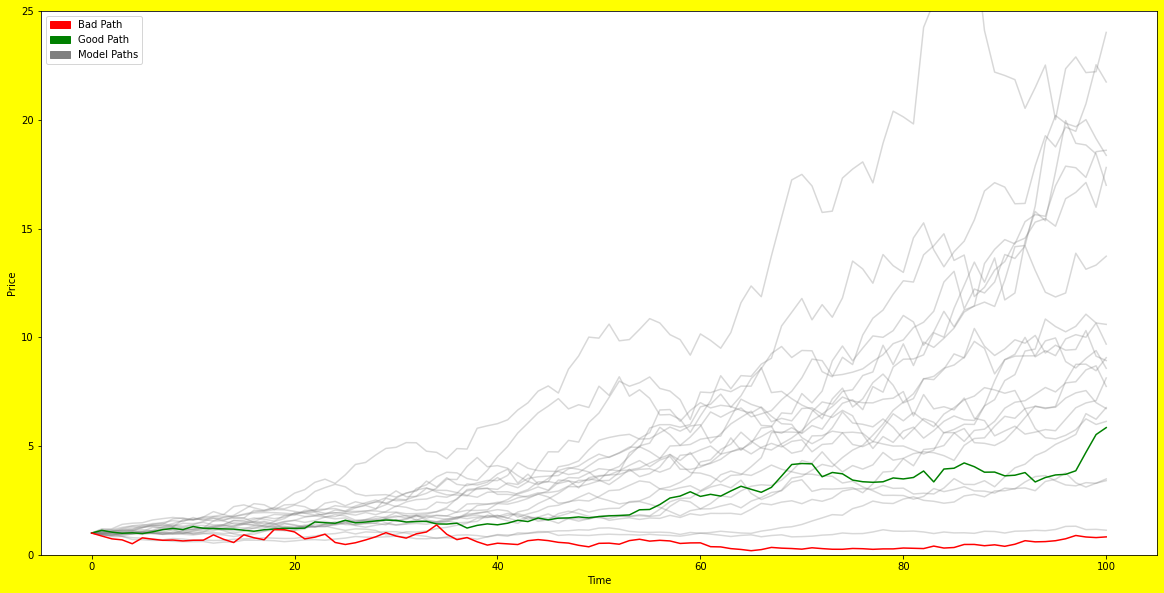

In [21]:
plt.figure(figsize=(20, 10),facecolor='yellow')
plt.plot(modelSamplePaths[0:20,:].T, c = 'grey', alpha = 0.3)
plt.plot(goodPath.T, c = 'green')
plt.plot(badPath.T, c = 'red')

red_patch = mpatches.Patch(color='red', label='Bad Path')
green_patch = mpatches.Patch(color='green', label='Good Path')
grey_patch = mpatches.Patch(color='grey', label='Model Paths')

plt.legend(loc="upper left",handles=[red_patch, green_patch, grey_patch])
plt.xlabel('Time')
plt.ylabel('Price')
plt.ylim([0,25])

plt.show()

In [22]:
#Let's go and compute the PITs. Start by getting the ECDFs at different time steps

ECDFs = []
for i in range(n_samples):
    ECDFs.append(empirical_distribution.ECDF(modelSamplePaths[:,i+1]-modelSamplePaths[:,i]))
#Notice the difference in above formula. It occurs because we are testing for a 0-hypothesis that involves the 
#increments of the stochastic process.

goodPathPITValues = np.empty(n_samples)
badPathPITValues = np.empty(n_samples)

# Computing the respective PIT values
for i, ECDF in enumerate(ECDFs):
    goodPathPITValues[i] = ECDF(goodPath[:,i+1]-goodPath[:,i])
    badPathPITValues[i] = ECDF(badPath[:,i+1]-badPath[:,i])

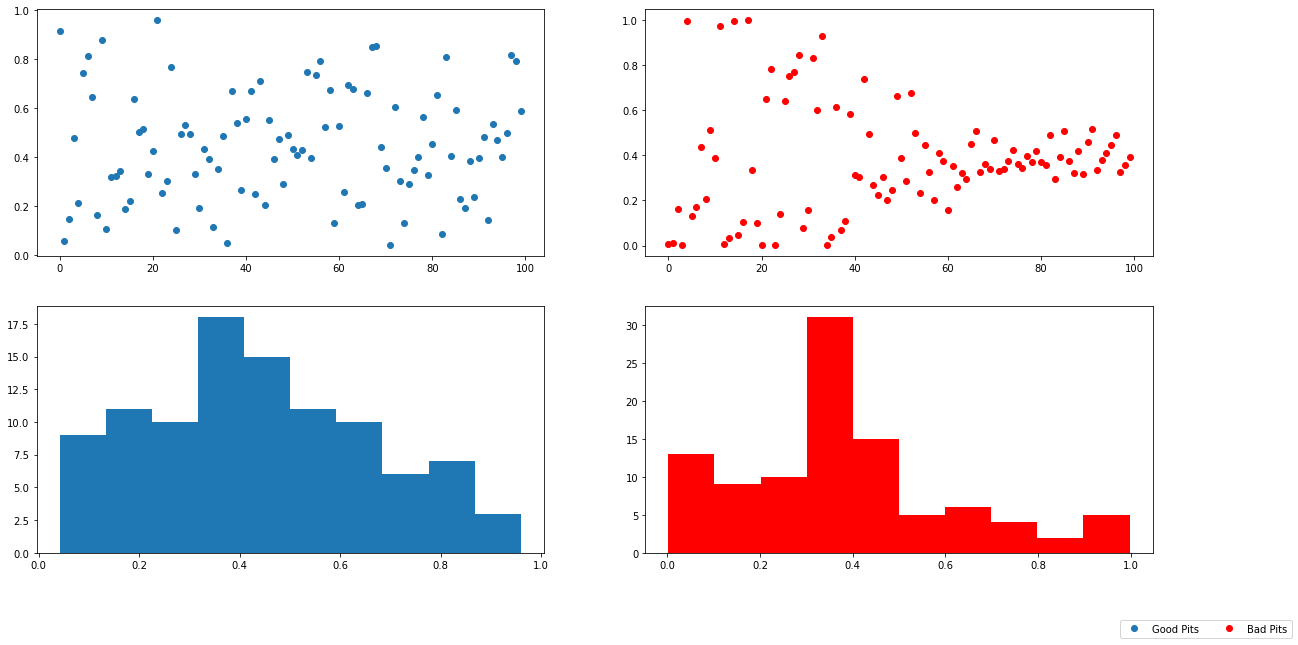

In [23]:
#Plot p values and histograms to visually assess if they are uniform

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(goodPathPITValues, 'o')
axs[0, 1].plot(badPathPITValues, 'o', c = 'red')
axs[1, 0].hist(goodPathPITValues, bins =10)
axs[1, 1].hist(badPathPITValues, bins =10, color = 'red')

fig.legend(['Good Pits','Bad Pits'], loc='lower right', bbox_to_anchor=(1,0.0), ncol=2, bbox_transform=fig.transFigure)

In [24]:
# We run classical statistical tests to check if the sample truely came from the model

# Let's start with the good sample
ksGoodPathTest = ss.kstest(goodPathPITValues, 'uniform') #Kholmogorov Smirnoff Test
cmGoodPathTest = ss.cramervonmises(goodPathPITValues, 'uniform') #Cramer von Mises Test

# What about the bad sample?
ksBadPathTest = ss.kstest(badPathPITValues, 'uniform') #Kholmogorov Smirnoff Test
cmBadPathCMTest = ss.cramervonmises(badPathPITValues, 'uniform') #Cramer von Mises Test

In [25]:
#Print the measured test statistics and pValues.

print('Good path sample: ' + str(ksGoodPathTest))
print('Good path sample: ' + str(cmGoodPathTest))

print('Bad path sample: ' + str(ksBadPathTest))
print('Bad path sample: ' + str(cmBadPathCMTest))

Good path sample: KstestResult(statistic=0.16709999999999992, pvalue=0.006563991874560332)
Good path sample: CramerVonMisesResult(statistic=0.8389461033333331, pvalue=0.005782058662836542)
Bad path sample: KstestResult(statistic=0.30479999999999996, pvalue=9.646105041474675e-09)
Bad path sample: CramerVonMisesResult(statistic=2.392500913333333, pvalue=1.3312117776997923e-06)


In a real-world setting a stochastic process will be callibrated to the market and the
realized path will be a sequence of historic market realizations.

# Limitations

The non-stationarity of the stochastic model and the reliance on a single realized path for testing entail important limitations. We illustrate some points by examples.

## The presence of drifts can be misleading

We construct an example, which is characterized by 
 1. No apparent relation between the stochastic model and the realized path;
 2. High p-Values in statistical tests.
 
For illustration we consider a simple model with a deterministic path, but the involved phenomenon is more general.
Its occurrence is related to the presence of drift. The $0$-hypothesis to be tested is whether a deterministic path is compatible with stochastic process with uniform increments. Though this hypothesis is clearly wrong, statistical tests have high p-Values.

In [14]:
#We assume a deterministic path and a uniform model
modelSamplePathsUni = np.cumsum(np.concatenate([np.ones((10000,1)), np.random.uniform(0, 1, size=(10000,100))], axis = 1),1)

#A bad path for illustration
badPath = 1 + np.cumsum(np.linspace(0,1,101))

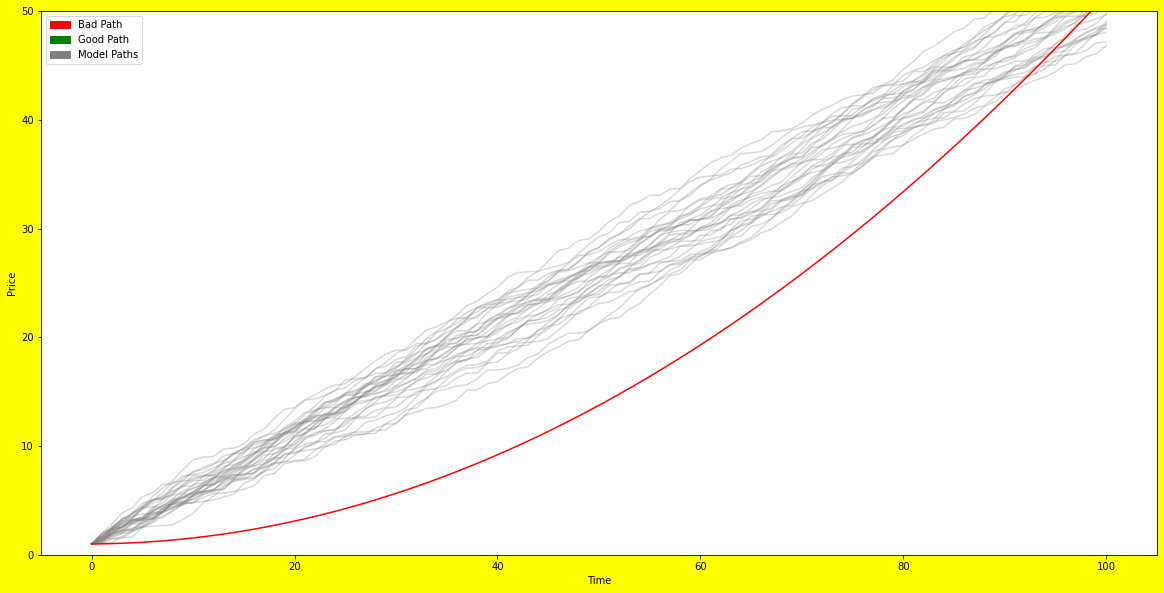

In [15]:
plt.figure(figsize=(20, 10),facecolor='yellow')
plt.plot(modelSamplePathsUni[0:30,:].T, c = 'grey', alpha = 0.3)
plt.plot(badPath, c = 'red')

red_patch = mpatches.Patch(color='red', label='Bad Path')
grey_patch = mpatches.Patch(color='grey', label='Model Paths')

plt.legend(loc="upper left",handles=[red_patch, green_patch, grey_patch])
plt.xlabel('Time')
plt.ylabel('Price')
plt.ylim([0,50])

plt.show()

In [16]:
#Let's compute the PITs. Start by getting the ECDFs at different time steps

ECDFs = []
for i in range(n_samples):
    ECDFs.append(empirical_distribution.ECDF(modelSamplePathsUni[:,i+1]-modelSamplePathsUni[:,i]))

badPathPITValues = np.empty(n_samples)

# Computing the respective PIT values
for i, ECDF in enumerate(ECDFs):
    badPathPITValues[i] = ECDF(badPath[i+1]-badPath[i])

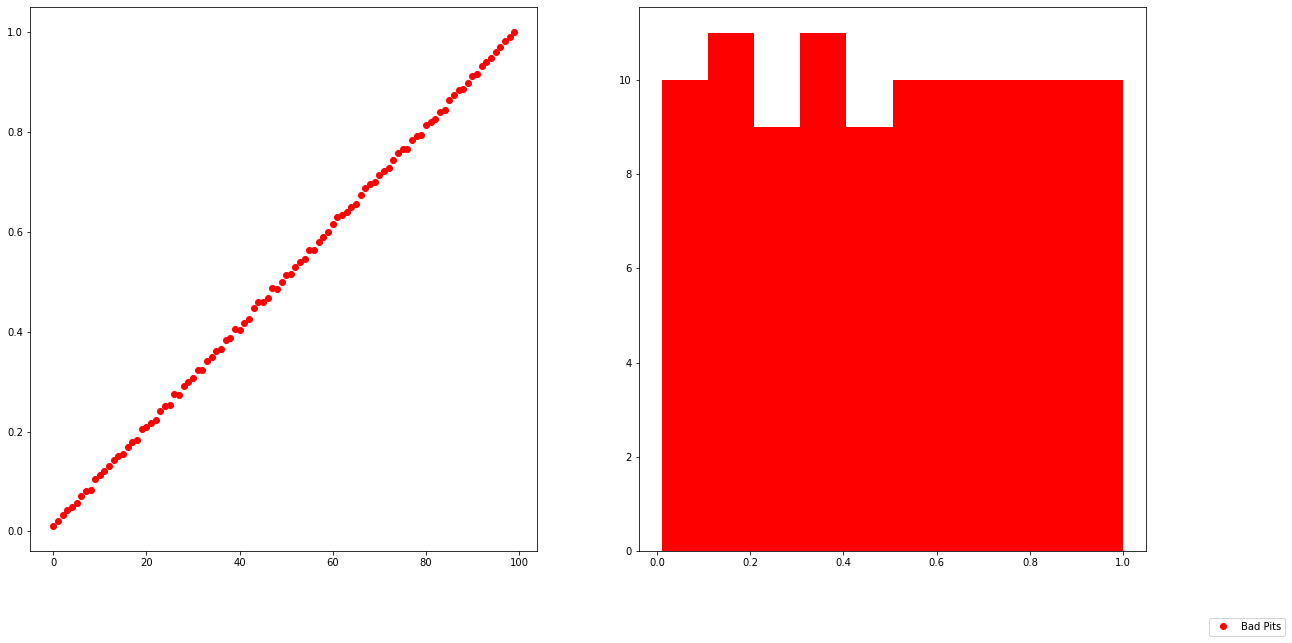

In [17]:
#Plot p values and histograms to visually assess if they are uniform

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(badPathPITValues, 'o', c = 'red')
axs[1].hist(badPathPITValues, bins =10, color = 'red')

fig.legend(['Bad Pits'], loc='lower right', bbox_to_anchor=(1,0.0), ncol=2, bbox_transform=fig.transFigure)

In [18]:
# We run classical statistical tests to check if the sample truely came from the model

ksBadPathTest = ss.kstest(badPathPITValues, 'uniform') #Kholmogorov Smirnoff Test
cmBadPathCMTest = ss.cramervonmises(badPathPITValues, 'uniform') #Cramer von Mises Test

The stochastic model has uniform increments and the realized path has drift that is characterized by increasing increments. The drift is chosen such as to ensure a small PIT in the beginning of the the testing episode, and a large PIT at the the end. The increase in PITs is essentially linear. The collection of PITs over all involved time steps presents itself as a uniform distribution. Being clearly wrong the $0$-hypothesis has high p-Values. The point is that if multiple realized paths could be compared at each time step statistical tests would be able to reject the hypothesis.